<a href="https://colab.research.google.com/github/Kishara0/Predicta-1.0_Predict_the_Unpredictable/blob/main/Predicta_1_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load datasets from Google Drive
historical_weather = pd.read_csv('/content/drive/MyDrive/historical_weather.csv')

# Display the first few rows
print(historical_weather.head())

# Check for missing values
print(historical_weather.isnull().sum())


  city_id        date  avg_temp_c  min_temp_c  max_temp_c  precipitation_mm  \
0    C001  2014-01-01         6.6        -1.4        11.6               NaN   
1    C001  2014-01-02         9.3         6.3        13.3               NaN   
2    C001  2014-01-03         7.6         1.9        14.0               NaN   
3    C001  2014-01-04         7.6         3.9        13.3               NaN   
4    C001  2014-01-05         8.6         0.5        16.9               NaN   

   snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  
0            NaN             168.0                 6.2  
1            NaN             155.0                10.0  
2            NaN               NaN                 5.8  
3            NaN             291.0                11.3  
4            NaN               NaN                 5.0  
city_id                    0
date                       0
avg_temp_c              1224
min_temp_c              5886
max_temp_c              7493
precipitation_mm       69744
snow_dept

**statistics**

          avg_temp_c     min_temp_c     max_temp_c  precipitation_mm  \
count  181114.000000  176452.000000  174845.000000     112594.000000   
mean       19.137516      14.627775      23.887261          3.679964   
std         9.902722      10.004998      10.446670         11.294167   
min       -34.700000     -43.800000     -28.500000          0.000000   
25%        12.400000       7.500000      17.100000          0.000000   
50%        21.400000      16.200000      27.000000          0.000000   
75%        27.100000      23.300000      31.500000          2.300000   
max        41.900000      38.900000      49.100000        496.100000   

       snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  
count   12238.000000     146944.000000       159866.000000  
mean      342.481696        175.650289           11.281875  
std      1020.265388        105.435150            6.132884  
min         0.000000          0.000000            0.000000  
25%         0.000000         83.000000        

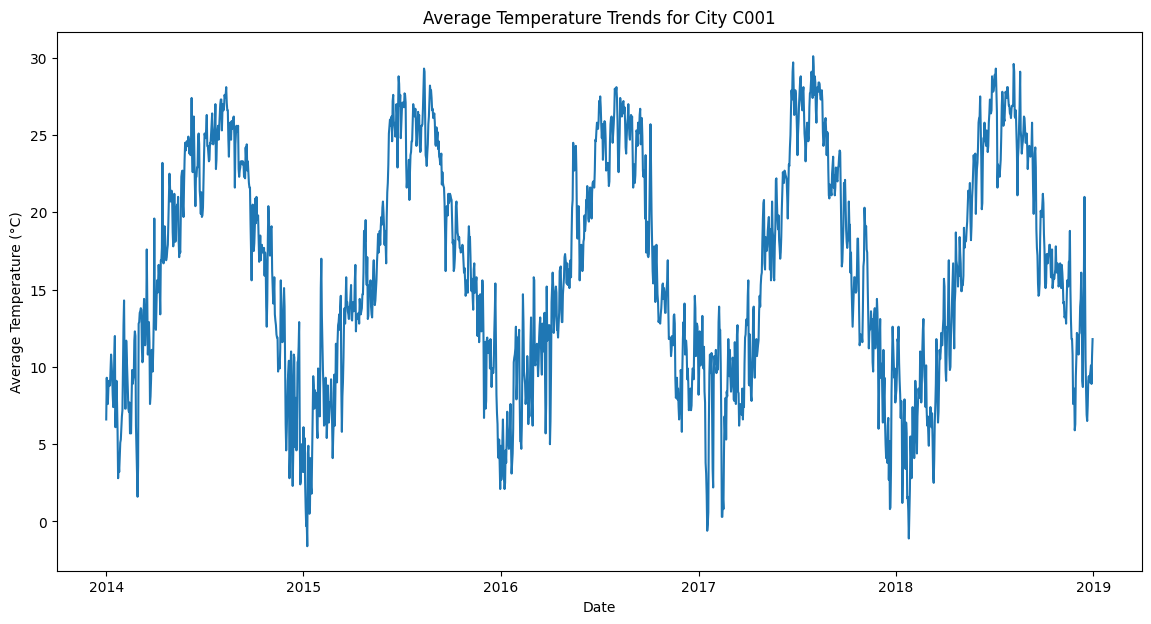

In [ ]:
# Summary statistics
print(historical_weather.describe())

# Plot temperature trends over time for a sample city
city_sample = historical_weather[historical_weather['city_id'] == 'C001']
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(city_sample['date']), city_sample['avg_temp_c'])
plt.title('Average Temperature Trends for City C001')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.show()


In [ ]:
# Drop the 'date' column as it's not needed for the model
data = historical_weather.drop(columns=['date'])

# Identify categorical columns
categorical_cols = ['city_id']

# Convert categorical columns to numeric using label encoding
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col].astype(str))

# Create an imputer to fill missing values with mean
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Verify there are no missing values
print(data_imputed.isnull().sum())


city_id               0
avg_temp_c            0
min_temp_c            0
max_temp_c            0
precipitation_mm      0
snow_depth_mm         0
avg_wind_dir_deg      0
avg_wind_speed_kmh    0
year                  0
month                 0
day_of_year           0
dtype: int64




> **Bulding Model**



In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Load and preprocess the data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofyear'] = df['date'].dt.dayofyear
    return df

# load the file path
historical_data = load_and_preprocess_data('/content/drive/MyDrive/historical_weather.csv')

# 2. Feature engineering
def create_features(df):
    df['temp_1d_lag'] = df.groupby('city_id')['avg_temp_c'].shift(1)
    df['temp_1w_lag'] = df.groupby('city_id')['avg_temp_c'].shift(7)
    df['temp_1m_lag'] = df.groupby('city_id')['avg_temp_c'].shift(30)
    df['temp_1y_lag'] = df.groupby('city_id')['avg_temp_c'].shift(365)

    # Create rolling averages
    df['temp_7d_avg'] = df.groupby('city_id')['avg_temp_c'].rolling(window=7).mean().reset_index(0, drop=True)
    df['temp_30d_avg'] = df.groupby('city_id')['avg_temp_c'].rolling(window=30).mean().reset_index(0, drop=True)

    return df

historical_data = create_features(historical_data)

# 3. Prepare the data for modeling
features = ['year', 'month', 'day', 'dayofyear', 'temp_1d_lag', 'temp_1w_lag', 'temp_1m_lag', 'temp_1y_lag', 'temp_7d_avg', 'temp_30d_avg']
X = historical_data[features].dropna()
y = historical_data.loc[X.index, 'avg_temp_c']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# 5. Evaluate the model
train_predictions = model.predict(X_train_scaled)
test_predictions = model.predict(X_test_scaled)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 0.655091459516315
Test RMSE: 1.734284941685503


**Get Predictions**

In [ ]:
# 6. Generate predictions for the submission period
def generate_submission_data(model, scaler, submission_key_path):
    # Load the submission key
    submission_key = pd.read_csv(submission_key_path)
    submission_key['date'] = pd.to_datetime(submission_key['date'])

    # Create features for the submission period
    submission_key['year'] = submission_key['date'].dt.year
    submission_key['month'] = submission_key['date'].dt.month
    submission_key['day'] = submission_key['date'].dt.day
    submission_key['dayofyear'] = submission_key['date'].dt.dayofyear

    # We need to get the lag features from the historical data
    # This assumes that the historical data covers the period just before the submission period
    last_historical_data = historical_data.groupby('city_id').last().reset_index()

    submission_data = pd.merge(submission_key, last_historical_data[['city_id', 'avg_temp_c', 'temp_7d_avg', 'temp_30d_avg']],
                               on='city_id', how='left')

    submission_data['temp_1d_lag'] = submission_data['avg_temp_c']
    submission_data['temp_1w_lag'] = submission_data['avg_temp_c']
    submission_data['temp_1m_lag'] = submission_data['avg_temp_c']
    submission_data['temp_1y_lag'] = submission_data['avg_temp_c']

    # Prepare features for prediction
    features = ['year', 'month', 'day', 'dayofyear', 'temp_1d_lag', 'temp_1w_lag', 'temp_1m_lag', 'temp_1y_lag', 'temp_7d_avg', 'temp_30d_avg']
    X_submission = submission_data[features]
    X_submission_scaled = scaler.transform(X_submission)

    # Make predictions
    predictions = model.predict(X_submission_scaled)

    # Create submission dataframe
    submission = pd.DataFrame({
        'submission_ID': submission_key['submission_ID'],
        'avg_temp_c': predictions
    })

    return submission

# Generate submission
submission_key_path = '/content/drive/MyDrive/submission_key.csv'
submission = generate_submission_data(model, scaler, submission_key_path)

# Save submission to CSV
submission.to_csv('/content/drive/MyDrive/submission.csv', index=False)

print("Submission file created successfully.")

Submission file created successfully.
